In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.tree

from helper import *
import swifter

In [2]:
# read the dataframe that contains all mechanical engineering students
df = pd.read_csv("МТ.txt", encoding="UTF-8", index_col=0, low_memory=False)
df.head(3)

# first corrections of the dataframe
df.rename(columns={'#Группы' : 'g_id',
                   '#Сессии' : 's_id',
                   'Номер зачетки' : 'st_id',
                   'ФИО' : 'name'},
          inplace=True);

df = df.replace({'5.0' : 5.0, '4.0' : 4.0, '3.0' : 3.0,
                 '5' : 5.0, '4' : 4.0, '3' : 3.0,
                 'False' : False, 'True' : True,
                 '\xa0\xa0\xa0\xa0' : float("nan")})

In [3]:
# adjust marks: the same subject can be both a categorical or a value type feature depending on the department and year

grouped_students = df.groupby(["g_id", "s_id"])

def adjust_group(gr: pd.DataFrame):
    gr_ = gr.dropna(axis=1, how="all")
    return gr_.apply(lambda col:
                        col.map(lambda mark: mark if type(mark) == float or pd.isna(mark)
                            else 2.0)
                        if col.map(lambda mark: type(mark) == float and not pd.isna(mark)).any()
                            else (col.map(lambda mark: mark if type(mark) == bool or pd.isna(mark)
                                else False))
                            if col.name not in ["g_id", "s_id", "name", "st_id"]
                                else col)

df = grouped_students.apply(adjust_group)
df.to_csv("adj_MT.csv", encoding="UTF-8")

In [4]:
# add a column of Group objects that encapsulate some logics

df["g_obj"] = df.g_id.apply(lambda gid: Group.from_string(gid))
# df["g_obj"].astype(type(Group))

In [5]:
# in order to predict the average mark of student we should include only data that contains all study years.
# group students by unique student id ant drop students that didn't pass the study course

# drop students who haven't passed exams and students with absent data
students = df.loc[(df.apply(lambda row: row.map(lambda mark: mark != 2.0 and mark != False).all(), axis=1)) & df.s_id <= 31]

# drop students who haven't completed the whole study course (8 semesters for bachelors and 12 for specialists)
tmp_groups = students.groupby("st_id").filter(lambda gr: gr.shape[0] == 8 or gr.shape[0] == 12).groupby("st_id")

filtered_students: list[pd.DataFrame] = []

for n, gr in tmp_groups:
    fltr = gr.dropna(axis=1, how="all")

    ses_seq = fltr.g_obj.map(lambda gobj: gobj.ses_id).sort_values().tolist()
    is_seq = ses_seq == list(range(1, 9, 1)) or ses_seq == list(range(1, 13, 1))
    if not is_seq: continue

    is_bac = fltr.g_id.apply(lambda gid: Group.from_string(gid).is_bac).any()
    is_sp = fltr.g_id.apply(lambda gid: Group.from_string(gid).is_sp).all()

    if (is_bac and fltr.shape[0] >= 8) or (is_sp and fltr.shape[0] >= 12):
        filtered_students.append(fltr)

filt = pd.concat(filtered_students)

In [7]:
# show students who had gaps during the study course

non_cons = []

for fs in filtered_students:
    s = fs.sort_values("s_id")
    ses_len = fs["s_id"].shape[0]
    seq = range(s.iloc[0]["s_id"], s.iloc[0]["s_id"] + ses_len, 1)
    if s["s_id"].tolist() != list(seq):
        non_cons.append(s)

In [266]:
# let's define features
# all operations will be performed on each student so let's define a pd.groupby object to work with
students = filt.groupby(["st_id"])

# let's choose student's id as unique identifier
st_id_ser = pd.Series(list(students.groups.keys()))
study_df = pd.DataFrame(index=st_id_ser)

In [511]:
# objective function: minimize(|real_mean - predicted_mean|) -> we need to define mean mark for each student

def calc_student_mean(st: pd.DataFrame, t_num : int = 12) -> float:
    # sort marks by the number of term (some subjects can repeat -> choose the last mark)
    subjs = st.dropna(axis=1, how="all").loc[st.g_obj.apply(lambda gobj: gobj.ses_id) <= t_num, :].sort_values("s_id", ascending=False).iloc[:, 4:]
    exam_subjs = subjs.loc[:, subjs.apply(lambda subj: subj.map(lambda mark: type(mark) == float and not pd.isna(mark)).any())]
    return exam_subjs.apply(lambda col: next(mark for mark in col.tolist() if type(mark) == float and not pd.isna(mark))).mean()

study_df["mean"] = students.apply(calc_student_mean)

# it is also important to know mean mark of the first and the most complicated years at the university

study_df["f_mean"] = students.apply(lambda st_gr: calc_student_mean(st_gr, 2))
study_df["s_mean"] = students.apply(lambda st_gr: calc_student_mean(st_gr, 4))

In [275]:
# let's define the most complicate subjects of the first year in order determine what subject should we include in our model

exams = filt.loc[:, filt.apply(lambda col:
                        col.map(lambda mark: type(mark) == float and not pd.isna(mark)).any() or col.name == "g_obj")]

exams.loc[exams.g_obj.map(lambda gobj: gobj.ses_id) <= 2].\
      apply(lambda col: col.loc[col.map(lambda mark: type(mark) == float)].mean()).\
      sort_values(ascending=True)

# let's add math, mechanics and physics marks as features
study_df["math"] = students.apply(lambda gr: next((mark for mark in gr.sort_values("s_id")["Математический анализ"].tolist()
                                                   if type(mark) == float and not pd.isna(mark)), float("nan")))
study_df["mech"] = students.apply(lambda gr: next((mark for mark in gr.sort_values("s_id")["Теоретическая механика"].tolist()
                                                   if type(mark) == float and not pd.isna(mark)), float("nan")))
study_df["phys"] = students.apply(lambda gr: next((mark for mark in gr.sort_values("s_id")["Физика"].tolist()
                                                   if type(mark) == float and not pd.isna(mark)), float("nan")))

In [357]:
# add gender

names = pd.read_csv("data/russian_names.csv", encoding="UTF-8", sep=";")
study_df["is_fem"] = students.apply(lambda gr: float("nan")
                                if names.loc[names.Name == gr.iloc[0]["name"].split()[1]].empty
                                else names.loc[names.Name == gr.iloc[0]["name"].split()[1]].iloc[0]["Sex"] == "Ж")

In [554]:
# add a feature that takes into account the study grade (bachelor or specialist)
study_df["is_bac"] = students.apply(lambda gr: gr.g_obj.map(lambda gobj: gobj.is_bac).any())

In [946]:
# final dataframe with all features
study_df.head(3)

,mean,f_mean,math,mech,phys,is_fem,s_mean,is_bac
08Т157,3.357143,3.000000,3.0,3.0,3.0,False,3.000000,False
09Т163,4.488372,4.000000,3.0,4.0,4.0,False,4.250000,False
09Т305,3.204082,3.111111,3.0,3.0,3.0,False,3.083333,False


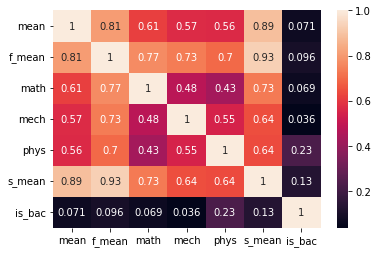

In [931]:
import seaborn as sns

# plot heatmap
sns.heatmap(study_df.dropna(how="any").corr(), annot = True);

In [944]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# build the model with all features
study = study_df.dropna(how="any")[["mean", "f_mean", "is_bac", "math", "mech", "phys", "is_fem"]]

X = study.apply(lambda row: row.iloc[1:].tolist(), axis=1).tolist()
y = study["mean"].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

regressor = DecisionTreeRegressor(max_depth=10)

regressor.fit(X_train, y_train)
print(f"MSE = {mean_squared_error(y_train, regressor.predict(X_train))}")
print(f"MAE = {mean_absolute_error(y_train, regressor.predict(X_train))}")

MSE = 0.03408371602303659
MAE = 0.12507804144532053


In [879]:
# my true mean mark is 4.35
regressor.predict([[4, True, 4, 4, 4, False]])

array([4.20578901])

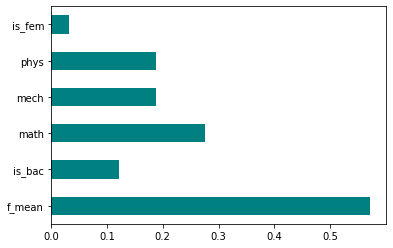

In [932]:
from sklearn.feature_selection import SelectKBest, SelectPercentile, mutual_info_regression

# show feature importance

importances = mutual_info_regression(X, y)
feature_importances = pd.Series(importances, study.columns[1:])
feature_importances.plot(kind='barh', color='teal');